# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
import numpy as np
import pandas as pd
import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [19]:
data = '/data/landmark_images'
train_path = os.path.join(data, 'train/')
test_path = os.path.join(data, 'test/')

In [20]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # input size for vgg16, resnet50 ...
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    #transforms.RandomVerticalFlip(), # Random vertical flip  
    transforms.ToTensor(), #Converting the input to tensor
    transforms.Normalize([0.5]*3, [0.5]*3) # Normalize the pixel values (in R, G, and B channels)
    ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), #Converting the input to tensor
    transforms.Normalize([0.5]*3, [0.5]*3) # Normalize the pixel values (in R, G, and B channels)
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_path,
                                  transform = train_transform)


test_data = datasets.ImageFolder(test_path,
                                 transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 
                   'valid': valid_loader, 
                   'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

**1a)** The code that I used resizes the images (using transforms.Resize) of both training & test sets to a **224x224** input image size. I used that input size, as I wanted my results of the first model to be comparable with those of the second task, where we will have to use transfer learning (vgg16, resnet50 etc, require 224x224 image size). However, the most efficient way to resize different sized images is to downscale them to match the dimensions from the smallest image available.

**1b)** I decided to use two different transforms, with only the one used for the training and validation sets having augmentation techniques. Apart from the normalization and the convertion of the inputs into tensors, only random horizontal flips where used. One reason that random horizontal flip was used was that the dataset consists of real-world pictures i.e. there is horizontal (or vertical) asymmetry. I decided to not use more data augmentation methods, as it would make the dataset even larger, and the training time of the model significantly greater.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

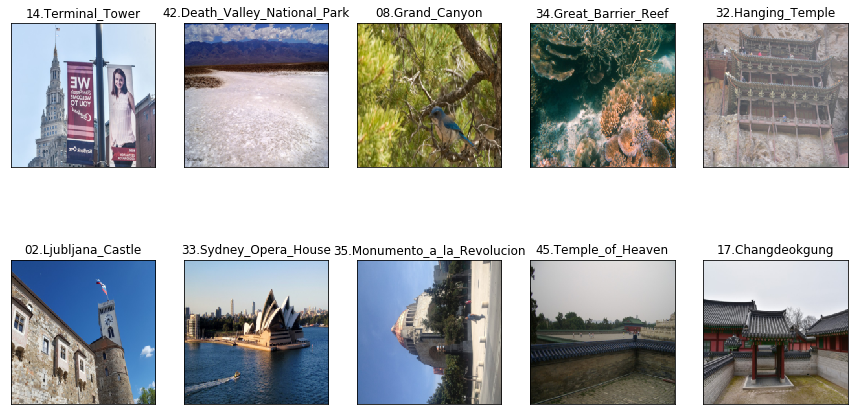

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# Helper function
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 8))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_data.classes[labels[idx]])


### Initialize use_cuda variable

In [21]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    # I decided to use Adam instead of SGD
    # According to Andrej Karpathy, 3e-4 is a good start...
    optimizer = optim.Adam(model.parameters(), lr=3e-4) 
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [14]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28x28x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14x14x64 tensor)
        # self.conv5 = nn.Conv2d(64, 128, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 14 * 14 -> 512)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        # linear layer (256 -> 50)
        self.fc3 = nn.Linear(256, 50)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)  
        
    
    def forward(self, x):
        ## Define forward behavior
        
        x = self.pool(F.relu(self.conv1(x))) # 224/2
        x = self.pool(F.relu(self.conv2(x))) # 112/2
        x = self.pool(F.relu(self.conv3(x))) # 56/2
        x = self.pool(F.relu(self.conv4(x))) # 28/2
        x = x.view(-1,128 * 14 * 14)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)      
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

The model taht I decided to use was similar to the one that was implemented to the cifar-10 problem. However, here I used an additional convolutional layer and an additional fully connected layer. I decided to use a more complex model, because here we have 224x224 images, and the number of classes is 50. After each conv layer, I used maxpooling layers to reduce the heights and widths of the tensors. Before proceeding to the fully connected layers, I used the *view* function to flatten the tensor in such a way that it has a shape that is equal to the number of elements contained to the tensor. After all fully connected layers (except the final one), I used dropout regularization, to avoid overfitting. I trained the algorithm for 10 epochs, with a test loss of approx. 2.8 and a test accuracy of 28%. At first glance, it seems that the model performs quite bad, but it shows a better behavior than guesses. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # 1.clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # 2.forward pass: compute predicted outputs by passing inputs to the model
            output = model_scratch(data)
            # 3.calculate the batch loss
            loss = criterion(output, target)
            # 4.backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # 5.perform a single optimization step (parameter update)
            optimizer.step()
            # 6.update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss
            # 1.forward pass: compute predicted outputs by passing inputs to the model
            output = model_scratch(data)
            # 2.calculate the batch loss
            loss = criterion(output, target)
            # 3.update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [16]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy

    classname = m.__class__.__name__
    # for every Linear layer in a model >
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.870321 	Validation Loss: 3.736400
Validation loss decreased (inf --> 3.736400).  Saving model ...
Epoch: 2 	Training Loss: 3.620607 	Validation Loss: 3.429753
Validation loss decreased (3.736400 --> 3.429753).  Saving model ...
Epoch: 3 	Training Loss: 3.377395 	Validation Loss: 3.213675
Validation loss decreased (3.429753 --> 3.213675).  Saving model ...
Epoch: 4 	Training Loss: 3.178670 	Validation Loss: 3.061540
Validation loss decreased (3.213675 --> 3.061540).  Saving model ...
Epoch: 5 	Training Loss: 2.976444 	Validation Loss: 2.982888
Validation loss decreased (3.061540 --> 2.982888).  Saving model ...
Epoch: 6 	Training Loss: 2.772106 	Validation Loss: 2.935078
Validation loss decreased (2.982888 --> 2.935078).  Saving model ...
Epoch: 7 	Training Loss: 2.561166 	Validation Loss: 2.827558
Validation loss decreased (2.935078 --> 2.827558).  Saving model ...
Epoch: 8 	Training Loss: 2.375828 	Validation Loss: 2.840456
Epoch: 9 	Training Loss: 2.141048 

**After 10th epoch, overfitting is apparent, hence for the next step I will train and validate for only 10 epochs**

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [17]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.868324 	Validation Loss: 3.754134
Validation loss decreased (inf --> 3.754134).  Saving model ...
Epoch: 2 	Training Loss: 3.651610 	Validation Loss: 3.461451
Validation loss decreased (3.754134 --> 3.461451).  Saving model ...
Epoch: 3 	Training Loss: 3.463251 	Validation Loss: 3.290828
Validation loss decreased (3.461451 --> 3.290828).  Saving model ...
Epoch: 4 	Training Loss: 3.249688 	Validation Loss: 3.167118
Validation loss decreased (3.290828 --> 3.167118).  Saving model ...
Epoch: 5 	Training Loss: 3.056803 	Validation Loss: 3.076811
Validation loss decreased (3.167118 --> 3.076811).  Saving model ...
Epoch: 6 	Training Loss: 2.896956 	Validation Loss: 2.989548
Validation loss decreased (3.076811 --> 2.989548).  Saving model ...
Epoch: 7 	Training Loss: 2.719276 	Validation Loss: 2.891140
Validation loss decreased (2.989548 --> 2.891140).  Saving model ...
Epoch: 8 	Training Loss: 2.549918 	Validation Loss: 2.877556
Validation loss decreased (2.89114

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.805326


Test Accuracy: 28% (354/1250)


In [1]:
# Accuracy is better than 20%

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [22]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 
                   'valid': valid_loader, 
                   'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [23]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=3e-4)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [24]:
from torchvision import models

## TODO: Specify model architecture

model_transfer = models.vgg19(pretrained=True)
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [25]:
print(model_transfer.classifier[6].in_features)
print(model_transfer.classifier[6].out_features)

4096
1000


In [26]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [27]:
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 50 classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 50)

model_transfer.classifier[6] = last_layer


In [28]:
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

In [29]:
# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

50


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

For this part of the CNN project, the model that I decided to use was the **VGG19**. I wanted to use a more complex model than VGG16, as I thought that it would 1) give better accuracy and 2) help preventing overfitting. I followed the guide for how to use transfer learning and I decided to change the last layer of the model, while I freezed the previous layers. I decided that as the dataset is not big enough, and the new data is similar to the original training data of the model. Here the number of inputs of the last layer (6th) was changed to 50, i.e. the classes that we have. Following that, I trained the model for the same number of epochs as the model_scratch, with a test loss of approx. 1.085 and a test accuracy of 72%; significantly higher than the model for the 1st task.  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [30]:
def train_transfer(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # 1.clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # 2.forward pass: compute predicted outputs by passing inputs to the model
            output = model_transfer(data)
            # 3.calculate the batch loss
            loss = criterion(output, target)
            # 4.backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # 5.perform a single optimization step (parameter update)
            optimizer.step()
            # 6.update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss
            # 1.forward pass: compute predicted outputs by passing inputs to the model
            output = model_transfer(data)
            # 2.calculate the batch loss
            loss = criterion(output, target)
            # 3.update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

In [31]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

num_epochs = 10

model_transfer = train_transfer(
    num_epochs, 
    loaders_transfer, 
    model_transfer, 
    get_optimizer_transfer(model_transfer), 
    criterion_transfer, use_cuda, 'model_transfer.pt'
                      )

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.144442 	Validation Loss: 1.370448
Validation loss decreased (inf --> 1.370448).  Saving model ...
Epoch: 2 	Training Loss: 1.101384 	Validation Loss: 1.176175
Validation loss decreased (1.370448 --> 1.176175).  Saving model ...
Epoch: 3 	Training Loss: 0.621715 	Validation Loss: 1.067689
Validation loss decreased (1.176175 --> 1.067689).  Saving model ...
Epoch: 4 	Training Loss: 0.434941 	Validation Loss: 1.327634
Epoch: 5 	Training Loss: 0.334205 	Validation Loss: 1.334706
Epoch: 6 	Training Loss: 0.264234 	Validation Loss: 1.396361
Epoch: 7 	Training Loss: 0.247267 	Validation Loss: 1.365582
Epoch: 8 	Training Loss: 0.247516 	Validation Loss: 1.478285
Epoch: 9 	Training Loss: 0.180294 	Validation Loss: 1.540041
Epoch: 10 	Training Loss: 0.188100 	Validation Loss: 1.611726


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
def test_transfer(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [33]:
test_transfer(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.085117


Test Accuracy: 72% (900/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [34]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), #Converting the input to tensor
    transforms.Normalize([0.5]*3, [0.5]*3) # Normalize the pixel values (in R, G, and B channels)
    ])

In [35]:
import re
  
def remove(listb):
    pattern = '[.0-9]'
    listb = [re.sub(pattern, '', i) for i in listb]
    return listb

In [44]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    # 1. Load the Images
    img = Image.open(img_path).convert('RGB')

    # 3. Image to tensor transformation
    img2tnsr = transform(img).float()
    img2tnsr = torch.unsqueeze(img2tnsr, 0)
    # 4. Move to GPU
    img2tnsr = img2tnsr.cuda()
    
    model_transfer.eval()
    output = model_transfer(img2tnsr)
    
    _, index = torch.topk(output.squeeze(0), k)
    lista = []
    for i in index:
        lista.append(train_loader.dataset.classes[i].replace("_"," "))
    return remove(lista)


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Eiffel Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

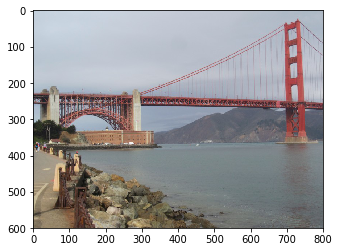

Is this picture of th  Golden Gate Bridge, Forth Bridge, or Brooklyn Bridge?


In [45]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()
    
    print(f"Is this picture of th  {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Given that the model accurately predicted 4 out of 5 images - or 5 out of 6, if we consider the previous one too, it seems that the algorithm works quite well, and even better than we expected. It might have a 72% accuracy on test set, but the model was tested on 5 different size images, and had 80% accuracy. 

A few suggestions to improve our model:
- change data augmentation techniques. From the training process, it is evident that there is quite significant overfitting. 
- Here a VGG19 model was used. However, we could change to a Resnet50 that it could probably perform even better.
- Different optimizer and learning curve. Changing the hyperparameters might prove beneficial to the model.
- It is also worth noticing, that with the overfitting overcomed, training for more epochs could give even higher accuracy.
- Change Mean & Std normalization techniques for the transforms. The ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) were used, but mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] would be even better, as these values were computed on the ImageNet dataset. 


In [46]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

import os # to interact with the uploaded images
cwd = os.getcwd()
cwd

'/home/workspace/nd101-c2-landmarks-starter/landmark_project'

In [47]:
PATH = cwd + '/'
PATH

'/home/workspace/nd101-c2-landmarks-starter/landmark_project/'

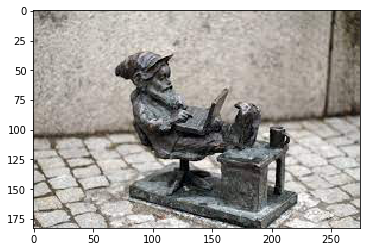

Is this picture of th  Wroclaws Dwarves, Hanging Temple, or Machu Picchu?


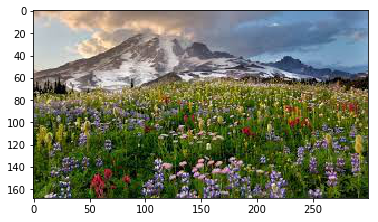

Is this picture of th  Matterhorn, Mount Rainier National Park, or Banff National Park?


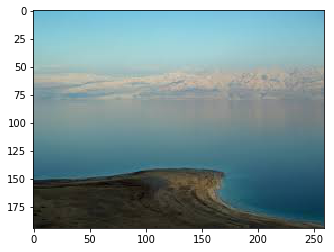

Is this picture of th  Death Valley National Park, Dead Sea, or Yellowstone National Park?


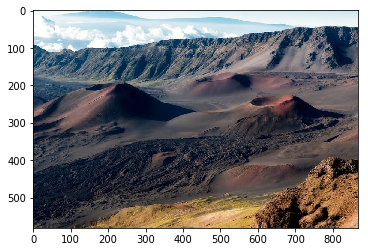

Is this picture of th  Mount Rainier National Park, Banff National Park, or Matterhorn?


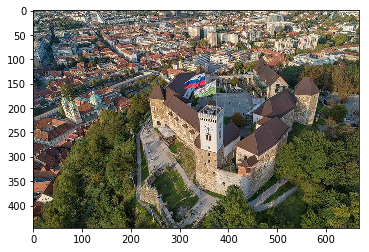

Is this picture of th  Grand Canyon, Ljubljana Castle, or Edinburgh Castle?


In [48]:
for image in os.listdir(PATH):
    if image.endswith('.jpg'):
        suggest_locations(PATH + image)

We see that the model correctly predicted 4 out of 5 images that we uploaded.